# Construct Portfolio (BS Data)

In [97]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# set the max columns to none
pd.set_option('display.max_columns', None)

In [32]:
bs_data = pd.read_csv("../data/sacerdote/bs_data.csv")
bs_data["evtdate"] = bs_data["evtdate"].apply(datetime.fromisoformat)
bs_data = bs_data.dropna(subset=["permno", "evtdate", "fecid"])
bs_data

,ticker,permno,siccd,evtdate,sell,buy,amount,amountE,asset,firstname,lastname,gender,fecid,govtrack_id,icpsr_id,votesmart_id,id,cid,date_of_birth,district,congress,party,seniority,frequent_trader
0,CBNK,91397.0,6036.0,2012-01-03,1.0,0.0,250k+,750000.5,Capital World Growth & Income Fund,Richard,Hanna,NaN,H8NY24066,NaN,NaN,NaN,NaN,N00030197,NaN,NY24,112.0,R,NaN,1.0
1,OPY,78451.0,6211.0,2012-01-03,0.0,1.0,100k-249k,175000.5,Oppenheimer Developing Markets Fund,Brad,Schneider,M,H2IL10068,412534.0,21326.0,134948.0,S001190,N00033101,1961-08-20,10,113.0,D,2.0,1.0
2,STZ,64899.0,2084.0,2012-01-03,1.0,0.0,1k-10k,8000.5,Constellation Brands,Adam,Schiff,M,H0CA27085,400361.0,20104.0,9489.0,S001150,N00009585,1960-06-22,29,112.0,D,12.0,0.0
3,HON,10145.0,3724.0,2012-01-03,0.0,1.0,1k-10k,8000.5,Honeywell International,Alan,Lowenthal,M,H2CA00104,412521.0,21313.0,16469.0,L000579,N00033274,1941-03-08,47,113.0,D,2.0,0.0
4,NUAN,82759.0,7372.0,2012-01-03,1.0,0.0,10k-49k,32500.5,Nuance Communications,Bill,Owens,NaN,H0NY23081,NaN,NaN,NaN,NaN,N00031011,NaN,NY23,112.0,D,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50599,SBUX,77702.0,5810.0,2020-12-18,1.0,0.0,1k-10k,1000.0,NaN,John,Larson,M,H8CT01046,400233.0,29908.0,17188.0,L000557,N00000575,1948-07-22,CT01,112.0,D,14.0,0.0
50601,OHI,77857.0,8062.0,2020-12-31,1.0,0.0,10k-49k,100000.0,NaN,Billy,Long,M,H0MO07113,412445.0,21150.0,123401.0,L000576,N00030676,1955-08-11,MO07,112.0,R,2.0,0.0
50602,SO,18411.0,4911.0,2020-12-31,1.0,0.0,1k-10k,50000.0,NaN,Billy,Long,M,H0MO07113,412445.0,21150.0,123401.0,L000576,N00030676,1955-08-11,MO07,112.0,R,2.0,0.0
50603,KMI,12558.0,4924.0,2020-12-31,1.0,0.0,50k-99k,50000.0,NaN,Billy,Long,M,H0MO07113,412445.0,21150.0,123401.0,L000576,N00030676,1955-08-11,MO07,112.0,R,2.0,0.0


## Create stock positions

In [66]:
def generate_position(data, END_DATE=datetime.fromisoformat("2020-12-31")):
    stocks = []
    evtdates = []
    evtdates_end = []
    positions = []
    init_pos = []
    for stock in np.unique(data["permno"]):
        stock_trans = data[data["permno"] == stock]
        positions += list(np.cumsum(stock_trans["transaction"]))
        stocks += [stock] * len(stock_trans)
        evtdates += list(stock_trans["evtdate"])
        evtdates_end += list(stock_trans["evtdate"].iloc[1:]) + [END_DATE]
        init_pos += [1] + [0] * (len(stock_trans)-1)
    return pd.DataFrame({"permno": stocks, "evtdate": evtdates, "evtdate_end": evtdates_end, "position": positions, "init_pos": init_pos})

In [67]:
def generate_position_all(bs_data):
    bs_data_w_positions = pd.DataFrame()
    for politician in np.unique(bs_data["fecid"]):
        p_data = bs_data[bs_data["fecid"]==politician].copy()
        p_data["transaction"] = -p_data["amountE"] * p_data["sell"] + p_data["amountE"] * p_data["buy"]
        p_data = p_data.sort_values("evtdate")
        p_data = p_data.merge(generate_position(p_data), on=["permno", "evtdate"])
        p_data = p_data[["ticker", "permno", "asset", "cid", "firstname", "lastname", 
                         "fecid", "evtdate", "evtdate_end", "transaction", "position", "init_pos"]]
        bs_data_w_positions = pd.concat([bs_data_w_positions, p_data])
    return bs_data_w_positions

In [72]:
bs_data_w_positions = generate_position_all(bs_data).sort_values(["fecid", "evtdate"]).reset_index()
bs_data_w_positions

,index,ticker,permno,asset,cid,firstname,lastname,fecid,evtdate,evtdate_end,transaction,position,init_pos
0,0,HD,66181.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-8000.5,-8000.5,1
1,1,GE,12060.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-8000.5,-8000.5,1
2,2,VALE,89330.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-115.0,-115.0,1
3,3,F,25785.0,NaN,N00030768,Martha,Roby,H0AL02087,2018-08-28,2020-12-31,-8000.5,-8000.5,1
4,0,AI,85653.0,NaN,N00030910,Mo,Brooks,H0AL05163,2013-06-10,2013-09-13,-1000.0,-1000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50095,3,PFE,21936.0,NaN,N00038734,Jacky,Rosen,S8NV00156,2020-11-17,2020-12-31,0.0,0.0,1
50096,0,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2013-06-17,2014-01-07,-4000.0,-4000.0,1
50097,1,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-01-07,2014-06-06,-2000.0,-6000.0,0
50098,2,RNWK,85576.0,NaN,N00007836,Maria,Cantwell,S8WA00194,2014-06-06,2016-04-28,-4000.0,-10000.0,0


## If we need the positions to be strictly non-negative

In [79]:
invalid_subset = bs_data_w_positions[bs_data_w_positions["position"] < 0][["permno", "fecid"]].drop_duplicates()
invalid_subset

,permno,fecid
0,66181.0,H0AL02087
1,12060.0,H0AL02087
2,89330.0,H0AL02087
3,25785.0,H0AL02087
4,85653.0,H0AL05163
...,...,...
50090,75104.0,S8NM00184
50092,83976.0,S8NV00156
50093,92618.0,S8NV00156
50094,70332.0,S8NV00156


In [87]:
drop_flags = []
for i in range(len(bs_data_w_positions)):
    if bs_data_w_positions["fecid"][i] in list(invalid_subset["fecid"]):
        if bs_data_w_positions["permno"][i] in list(invalid_subset[invalid_subset["fecid"]==bs_data_w_positions["fecid"][i]]["permno"]):
            drop_flags += [1]
            continue
    drop_flags += [0]
sum(drop_flags)

27091

In [101]:
bs_data_w_positions_nn = bs_data_w_positions[(1 - np.array(drop_flags)).astype(bool)]
bs_data_w_positions_nn

,index,ticker,permno,asset,cid,firstname,lastname,fecid,evtdate,evtdate_end,transaction,position,init_pos
16,12,IQNT,92454.0,NaN,N00030910,Mo,Brooks,H0AL05163,2014-08-18,2016-11-04,1000.0,1000.0,1
17,13,DRAD,90223.0,NaN,N00030910,Mo,Brooks,H0AL05163,2014-10-20,2015-01-05,1000.0,1000.0,1
18,14,SDLP,13633.0,NaN,N00030910,Mo,Brooks,H0AL05163,2014-11-03,2020-12-31,1000.0,1000.0,1
19,15,DRAD,90223.0,NaN,N00030910,Mo,Brooks,H0AL05163,2015-01-05,2020-12-31,-1000.0,0.0,0
20,16,SO,18411.0,NaN,N00030910,Mo,Brooks,H0AL05163,2015-10-01,2020-12-31,1000.0,1000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50084,1440,ALGN,88860.0,NaN,N00029617,Kay,Hagan,S8NC00239,2019-09-12,2020-12-31,1000.0,4000.0,0
50086,0,VZ,65875.0,Verizon Communications,N00029444,Mike,Johanns,S8NE00117,2012-02-29,2012-03-28,8000.5,8000.5,1
50087,1,VZ,65875.0,Verizon Communications,N00029444,Mike,Johanns,S8NE00117,2012-03-28,2012-07-26,8000.5,16001.0,0
50088,2,VZ,65875.0,Verizon Communications,N00029444,Mike,Johanns,S8NE00117,2012-07-26,2020-12-31,32500.5,48501.5,0


## Histogram

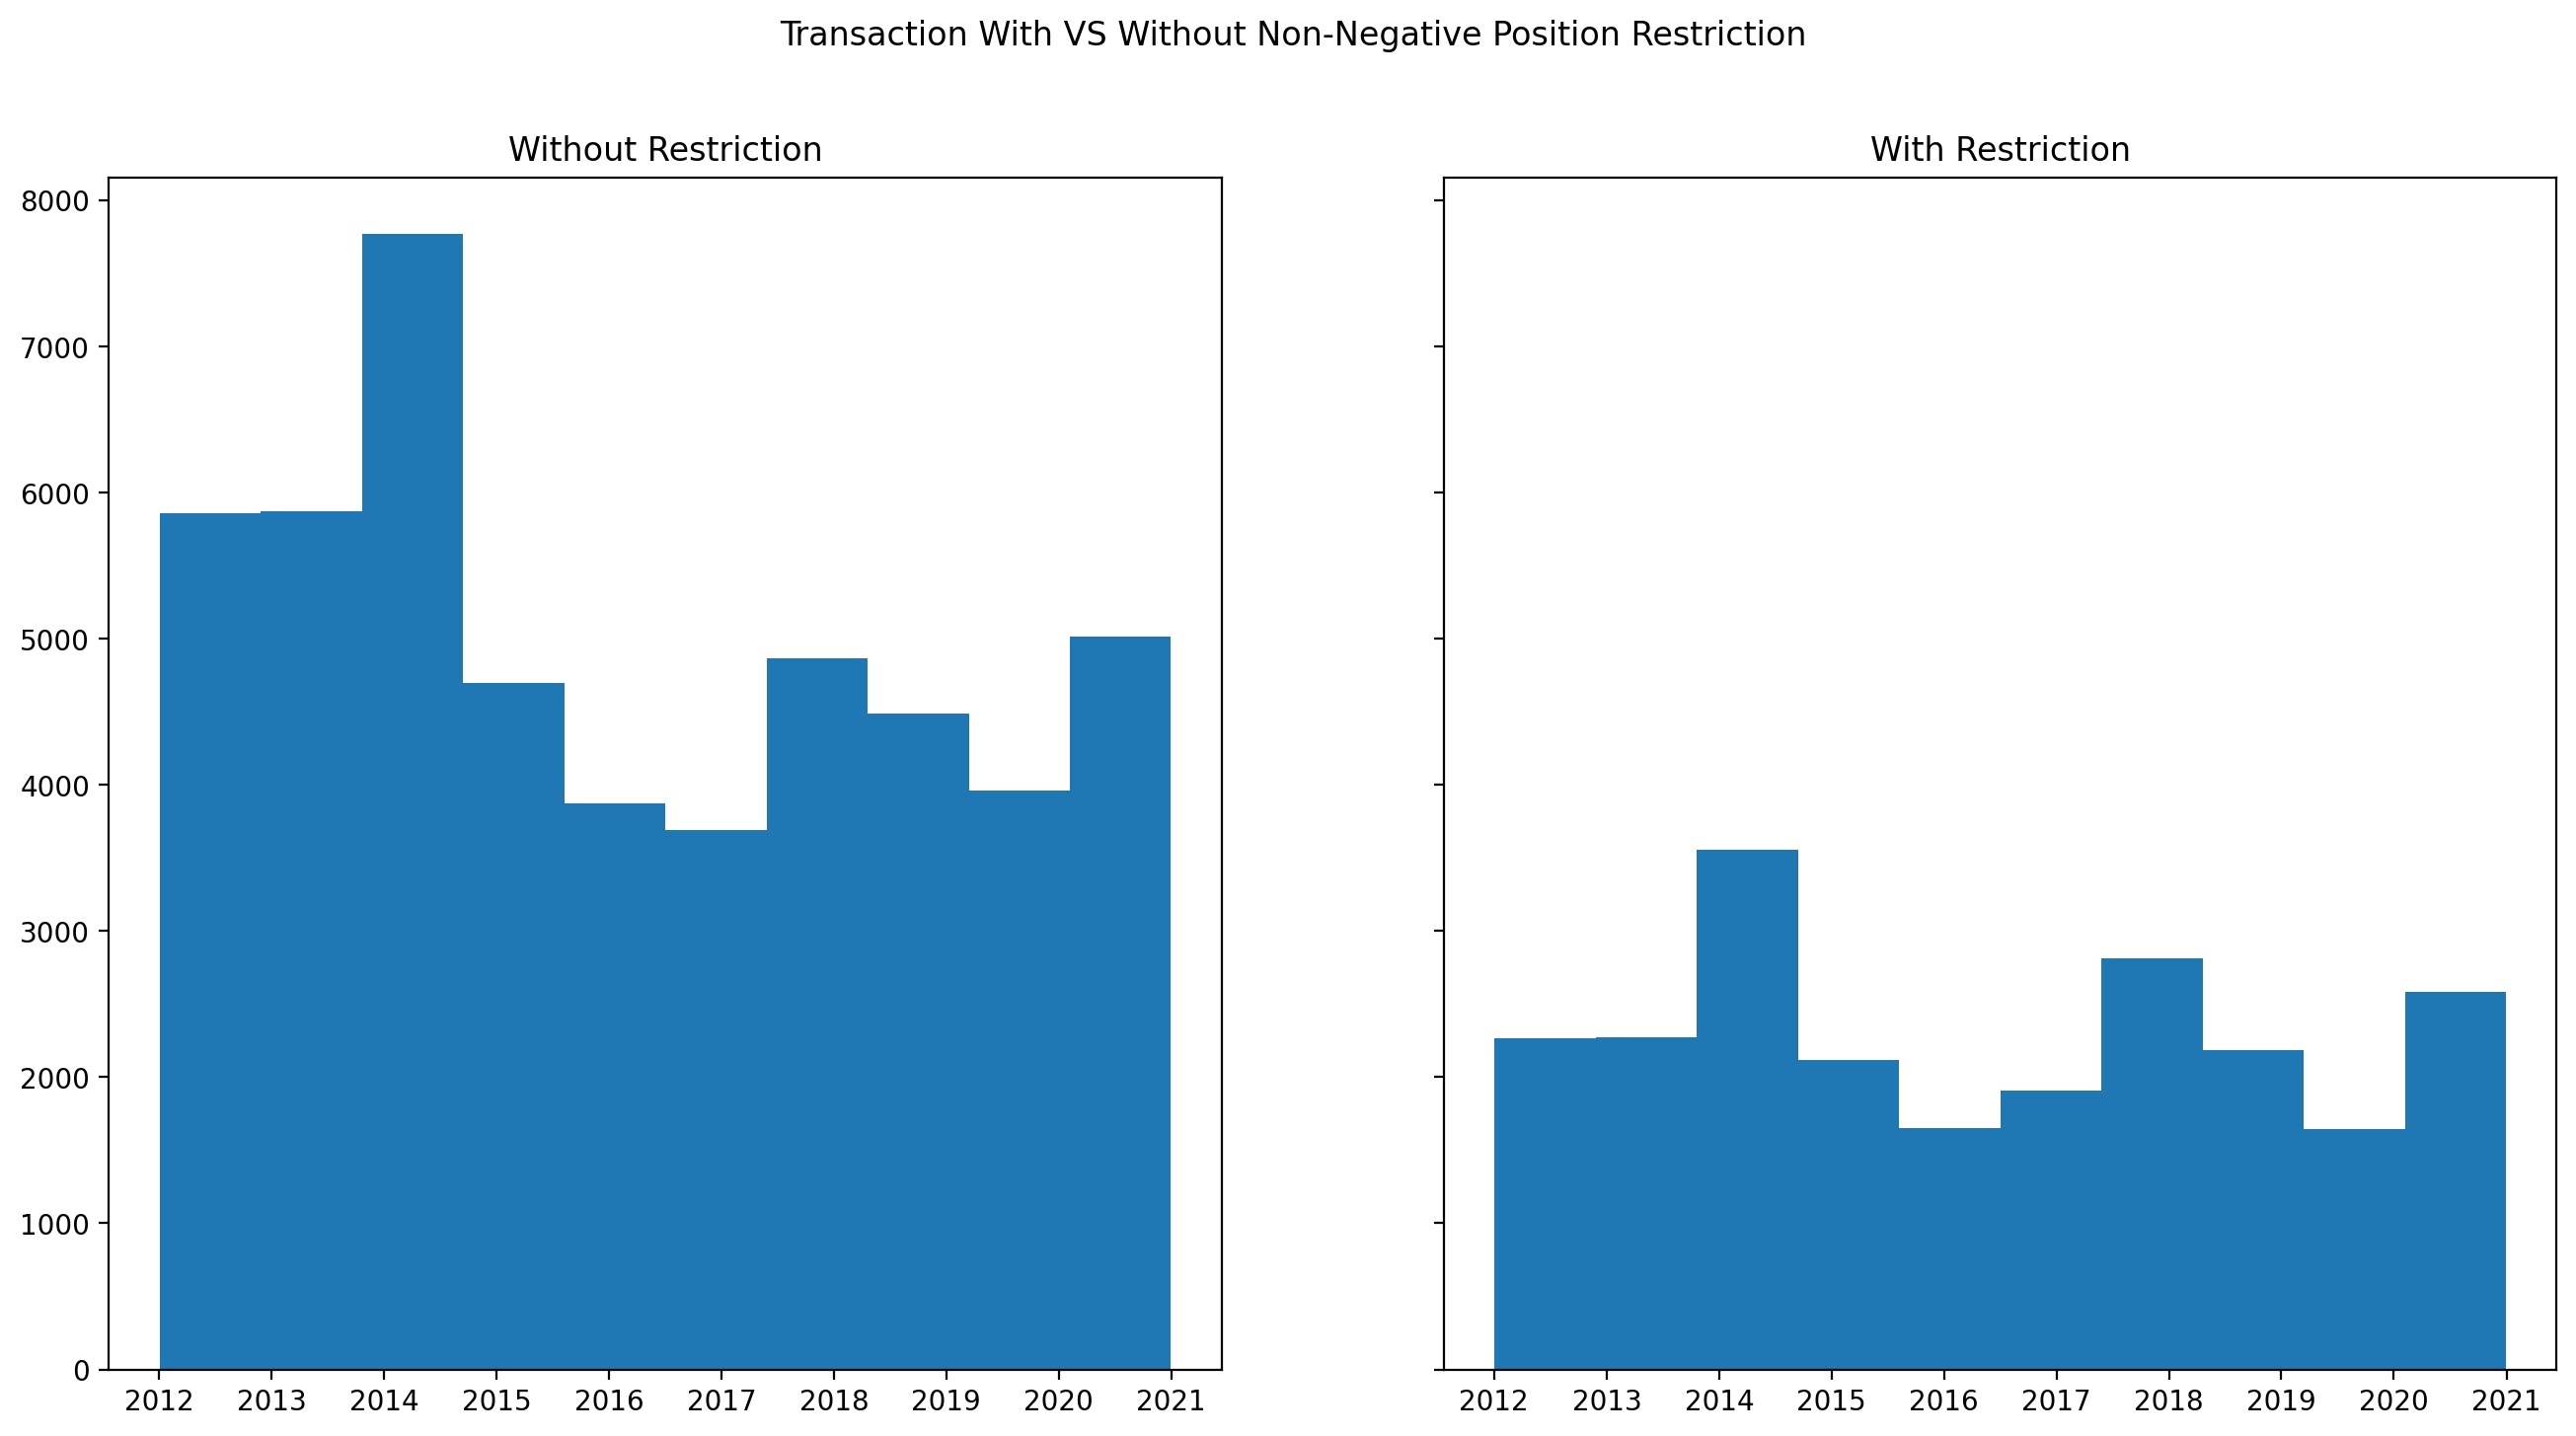

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True, dpi=200)
fig.suptitle("Transaction With VS Without Non-Negative Position Restriction")
ax1.hist(bs_data_w_positions["evtdate"])
ax1.set_title("Without Restriction")
ax2.hist(bs_data_w_positions_nn["evtdate"])
ax2.set_title("With Restriction")
plt.show()

## Write Dataset to Disk

In [114]:
bs_data_w_positions.to_csv("bs_data_w_positions.csv", index=False)
bs_data_w_positions_nn.to_csv("bs_data_w_positions_nn.csv", index=False)